# Ground Terrain Void Modeling and Reconstruction

The file is grabbed from: OpenGF Publicly available source: https://drive.google.com/drive/folders/1ud3fuiaNGHBiTVmIg36mrDarz-zzCzID It is part of https://github.com/Nathan-UW/OpenGF?tab=readme-ov-file repository. Paper link: https://openaccess.thecvf.com/content/CVPR2021W/EarthVision/html/Qin_OpenGF_An_Ultra-Large-Scale_Ground_Filtering_Dataset_Built_Upon_Open_ALS_CVPRW_2021_paper.html

This notebook performs the following steps:
1. Reads a LAZ file and extracts metadata and EDA
2. Filters ground points and calculates average point density with <i>ground_mask = (las.classification == 2)</i>
3. Generates random voids on terrain (rectangles)
4. Extracts true ground points within voids
5. Fits and extends planes into voids
6. Samples points to fill the voids with synthetic ground

VENV: pointcloud_venv

In [98]:
import laspy
import numpy as np
from numpy import unique
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon, Point
from pyproj import CRS
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import CubicSpline
from IPython.display import Image
from sklearn.metrics import mean_squared_error

# For PDE
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

In [2]:
pwd

'/Users/AFILA/Documents/WD_Mac/vens/pointcloud_venv/push_to_git/Code'

##### Refined Approach
<b>Initial Step:<b>

1.1. Start at Point A.<br>
1.2. Use A and any available points in the 1.5 m window to its left to fit the first line.<br>
1.3. Extend the fitted line 1.5 m forward in the X direction.<br>
1.4. Randomly sample 4 points on the extended segment and jitter them vertically.<br>

<b>Subsequent Iterations:<b>

2.1. Define a sliding window of width 2m.<br>
2.2. Shift it forward by Δx = 1m per iteration.<br>

<b>For each window:<b>

3.1. Select existing jittered points within the 2m rolling window.<br>
3.2. Fit a best-fit line to those points.<br>
3.3. Extend the line 1m forward.<br>
3.4. Sample 4 points on the extended part and jitter them.<br>

<b>This process ensures:<b>

* 2m overlap between consecutive windows (since 3m window size – 1m step).<br>
* A localised and adaptive fit that progressively builds the reconstruction front.<br>

### Test in 2D / Line-fitting

In [4]:
def fit_line_segment(points):
    """Fit a best-fit line to the given 2D points using linear regression."""
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept

def sample_and_jitter_line_segment(start_x, slope, intercept, sample_range, num_samples, max_jitter, y_ref):
    """
    Sample points along a line segment starting from start_x within sample_range,
    jitter them vertically, and return jittered samples.
    """
    sample_x = np.sort(np.random.uniform(start_x, start_x + sample_range, size=num_samples))
    sample_y = slope * sample_x + intercept

    jittered_points = []
    for x, y in zip(sample_x, sample_y):
        # Determine jitter direction
        if y < y_ref:
            jitter_y = y + np.random.uniform(0, max_jitter)
        else:
            jitter_y = y - np.random.uniform(0, max_jitter)
        jittered_points.append([x, jitter_y])
    return np.array(jittered_points)

In [5]:
A = np.array([0.0, 0.0])
B = np.array([10.0, 3.0])
initial_points = np.array([
    [-1.5, -0.2],
    [-1.0,  0.0],
    [-0.5,  0.1],
    [ 0.0,  0.0]  # Point A
])
jittered_points = initial_points.tolist()

In [6]:
# Iterative parameters
window_width = 3.0
step_size = 1.0
extension_length = 1.0
max_jitter = 0.4
num_samples = 4

# Iteration
x_current = 0.0  # Starting at A.x
iterations = 0
lines = []

In [7]:
while x_current < B[0]:
    # Define window range
    window_start = x_current - (window_width - extension_length)
    window_end = x_current

    # Select points within the current window
    points_in_window = np.array([p for p in jittered_points if window_start <= p[0] <= window_end])
    if len(points_in_window) < 2:
        break  # Not enough points to fit

    # Fit line to selected points
    slope, intercept = fit_line_segment(points_in_window)
    lines.append((slope, intercept, x_current, x_current + extension_length))

    # Sample and jitter new points
    new_samples = sample_and_jitter_line_segment(x_current, slope, intercept,
                                                 extension_length, num_samples, max_jitter, B[1])
    jittered_points.extend(new_samples.tolist())

    x_current += step_size
    iterations += 1
    if iterations > 15:
        break  # Safety stop

In [8]:
# Convert to array for plotting
jittered_points = np.array(jittered_points)

In [10]:
jittered_points

array([[-1.5       , -0.2       ],
       [-1.        ,  0.        ],
       [-0.5       ,  0.1       ],
       [ 0.        ,  0.        ],
       [ 0.19508665,  0.22131719],
       [ 0.28183501,  0.14443851],
       [ 0.54928309,  0.45714879],
       [ 0.87697749,  0.4634244 ],
       [ 1.16255295,  0.48182049],
       [ 1.56893731,  0.84497766],
       [ 1.63884223,  0.94914509],
       [ 1.75608864,  0.69037678],
       [ 2.03453979,  1.33760937],
       [ 2.36901766,  1.52655763],
       [ 2.43823063,  1.44216626],
       [ 2.94229888,  1.57569134],
       [ 3.37429327,  2.10189274],
       [ 3.43236344,  2.47040884],
       [ 3.73972   ,  2.67652675],
       [ 3.87697001,  2.75539767],
       [ 4.53883612,  2.92619572],
       [ 4.558206  ,  2.86924544],
       [ 4.84024837,  3.32025993],
       [ 4.86600178,  3.2857662 ],
       [ 5.01937398,  3.17631084],
       [ 5.38380832,  3.27167278],
       [ 5.58380728,  3.4833536 ],
       [ 5.7380623 ,  3.37772209],
       [ 6.38676917,

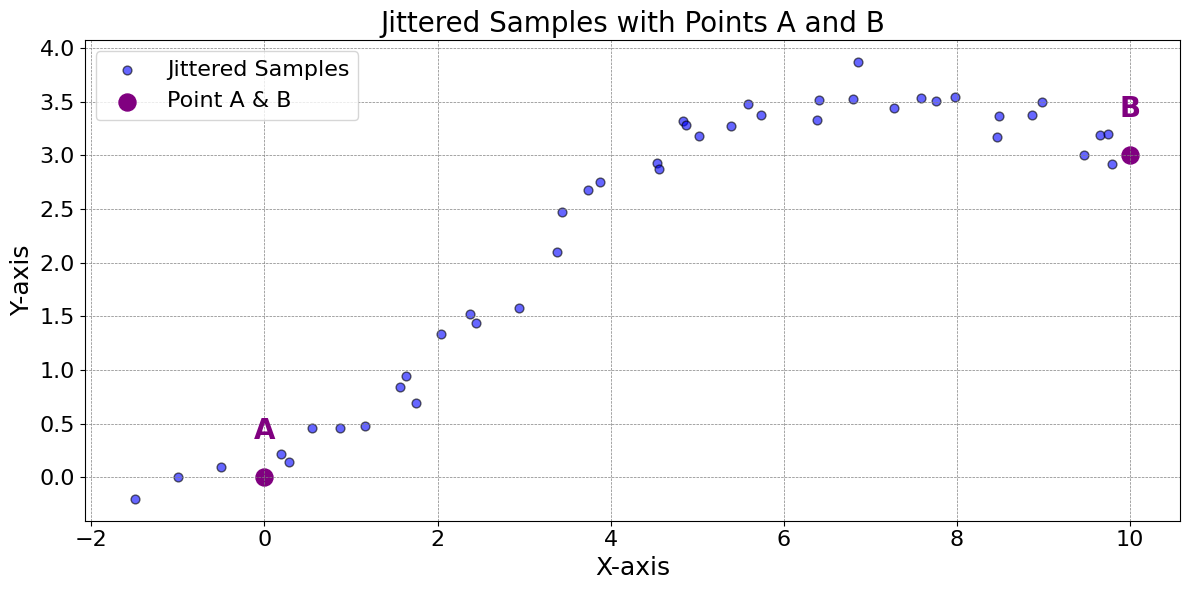

In [11]:
# Vizualize
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_facecolor('white')

# Plot jittered samples
plt.scatter(jittered_points[:, 0], jittered_points[:, 1],
            c='blue', label='Jittered Samples', alpha=0.6, edgecolors='k', s=40)

# Plot Points A and B (same color and size)
plt.scatter(*A, color='purple', s=150, label='Point A & B')
plt.scatter(*B, color='purple', s=150)

# Annotate points (above, no arrow)
plt.text(A[0], A[1] + 0.3, 'A', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')
plt.text(B[0], B[1] + 0.3, 'B', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')

# Grid and axes formatting
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend(fontsize=16)
plt.title("Jittered Samples with Points A and B", fontsize=20)
plt.xlabel("X-axis", fontsize=18)
plt.ylabel("Y-axis", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


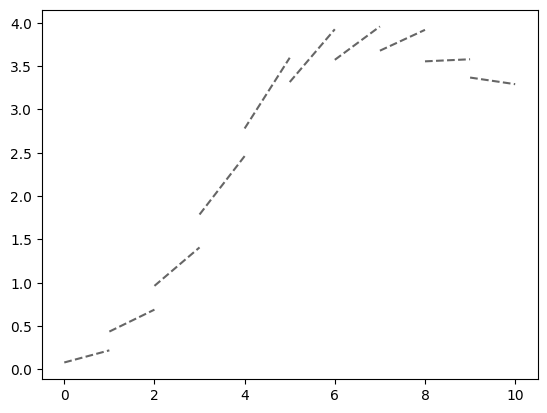

In [12]:
# Plot lines
for slope, intercept, x_start, x_end in lines:
    x_vals = np.linspace(x_start, x_end, 10)
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, 'k--', alpha=0.6)

### Test: (bi-directional w/o weight adjustment)

In [13]:
def fit_line_segment(points):
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    return slope, intercept

def sample_and_jitter_equidistant(start_x, slope, intercept, sample_range, num_samples, max_jitter, y_ref, reverse=False):
    dx = sample_range / (num_samples + 1)
    if reverse:
        sample_x = np.linspace(start_x - dx, start_x - sample_range + dx, num_samples)
        weights = (start_x - sample_x) / sample_range
    else:
        sample_x = np.linspace(start_x + dx, start_x + sample_range - dx, num_samples)
        weights = (sample_x - start_x) / sample_range

    sample_y = slope * sample_x + intercept
    jittered_points = []
    for x, y, w in zip(sample_x, sample_y, weights):
        jitter_mag = (w ** 2) * max_jitter  # smoother jitter
        jitter_y = y + jitter_mag if y < y_ref else y - jitter_mag
        jittered_points.append([x, jitter_y])
    return np.array(jittered_points)


In [14]:
# Parameters and seed data
A = np.array([0.0, 0.0])
B = np.array([10.0, 3.0])
initial_points_A = np.array([[-1.5, -0.2], [-1.0, 0.0], [-0.5, 0.1], [0.0, 0.0]])
initial_points_B = np.array([[11.5, 3.1], [11.0, 2.8], [10.5, 2.9], [10.0, 3.0]])

step_size = 1.0
max_jitter = 0.2
num_samples = 4
merge_threshold = 0.3

In [15]:
# Forward from A
jittered_A = initial_points_A.tolist()
x_current_A = A[0]
lines_A = []
first_extension_A = True

while x_current_A < B[0]:
    fit_range = 2.0 if not first_extension_A else 1.5
    extension = 1.0 if not first_extension_A else 1.5
    win_start = x_current_A - fit_range
    points_in_win = np.array([p for p in jittered_A if win_start <= p[0] <= x_current_A])
    if len(points_in_win) < 2:
        break
    slope, intercept = fit_line_segment(points_in_win)
    lines_A.append((slope, intercept, x_current_A, x_current_A + extension))
    new_samples = sample_and_jitter_equidistant(x_current_A, slope, intercept,
                                                extension, num_samples, max_jitter, B[1])
    jittered_A.extend(new_samples.tolist())
    x_current_A += step_size
    first_extension_A = False
    if x_current_A > B[0] - merge_threshold:
        break

In [16]:
# Backward from B
jittered_B = initial_points_B.tolist()
x_current_B = B[0]
lines_B = []
first_extension_B = True

while x_current_B > A[0]:
    fit_range = 2.0 if not first_extension_B else 1.5
    extension = 1.0 if not first_extension_B else 1.5
    win_end = x_current_B + fit_range
    points_in_win = np.array([p for p in jittered_B if x_current_B <= p[0] <= win_end])
    if len(points_in_win) < 2:
        break
    slope, intercept = fit_line_segment(points_in_win)
    lines_B.append((slope, intercept, x_current_B, x_current_B - extension))
    new_samples = sample_and_jitter_equidistant(x_current_B, slope, intercept,
                                                extension, num_samples, max_jitter, A[1], reverse=True)
    jittered_B.extend(new_samples.tolist())
    x_current_B -= step_size
    first_extension_B = False
    if x_current_B < A[0] + merge_threshold:
        break

In [63]:
all_points = jittered_A + jittered_B

In [64]:
all_points_array = np.array(all_points)

In [65]:
# Sort by x-values:
all_points_sorted = all_points_array[np.argsort(all_points_array[:,0])]

In [66]:
# Check for duplicates (for input into SPline func.)
_, unique_indices = np.unique(all_points_sorted[:, 0], return_index = True)
all_points_ddup = all_points_sorted[sorted(unique_indices)]

In [70]:
all_points_ddup

array([[-1.50000000e+00, -2.00000000e-01],
       [-1.00000000e+00,  0.00000000e+00],
       [-5.00000000e-01,  1.00000000e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.00000000e-01, -4.79113773e-01],
       [ 3.00000000e-01,  1.30000000e-01],
       [ 4.00000000e-01, -4.26959490e-01],
       [ 6.00000000e-01, -3.58805207e-01],
       [ 8.00000000e-01, -2.74650924e-01],
       [ 9.00000000e-01,  2.78000000e-01],
       [ 1.20000000e+00,  7.00424683e-03],
       [ 1.40000000e+00,  3.23345357e-01],
       [ 1.60000000e+00,  3.89124916e-01],
       [ 1.80000000e+00,  2.18611782e-01],
       [ 2.20000000e+00,  4.22768769e-01],
       [ 2.40000000e+00,  5.78083946e-01],
       [ 2.60000000e+00,  7.17399124e-01],
       [ 2.80000000e+00,  8.40714302e-01],
       [ 3.20000000e+00,  8.96987448e-01],
       [ 3.40000000e+00,  1.15052532e+00],
       [ 3.60000000e+00,  1.27329902e+00],
       [ 3.80000000e+00,  1.38007271e+00],
       [ 4.20000000e+00,  1.51794509e+00],
       [ 4.

In [74]:
len(all_points_ddup)

52

In [75]:
x_vals = all_points_ddup[:, 0]
y_vals = all_points_ddup[:, 1]

In [76]:
len(x_vals)

52

In [77]:
len(y_vals)

52

In [78]:
# Interpolate and plot
spline = CubicSpline(x_vals, y_vals)
x_interp = np.linspace(x_vals.min(), x_vals.max(), 300)
y_interp = spline(x_interp)

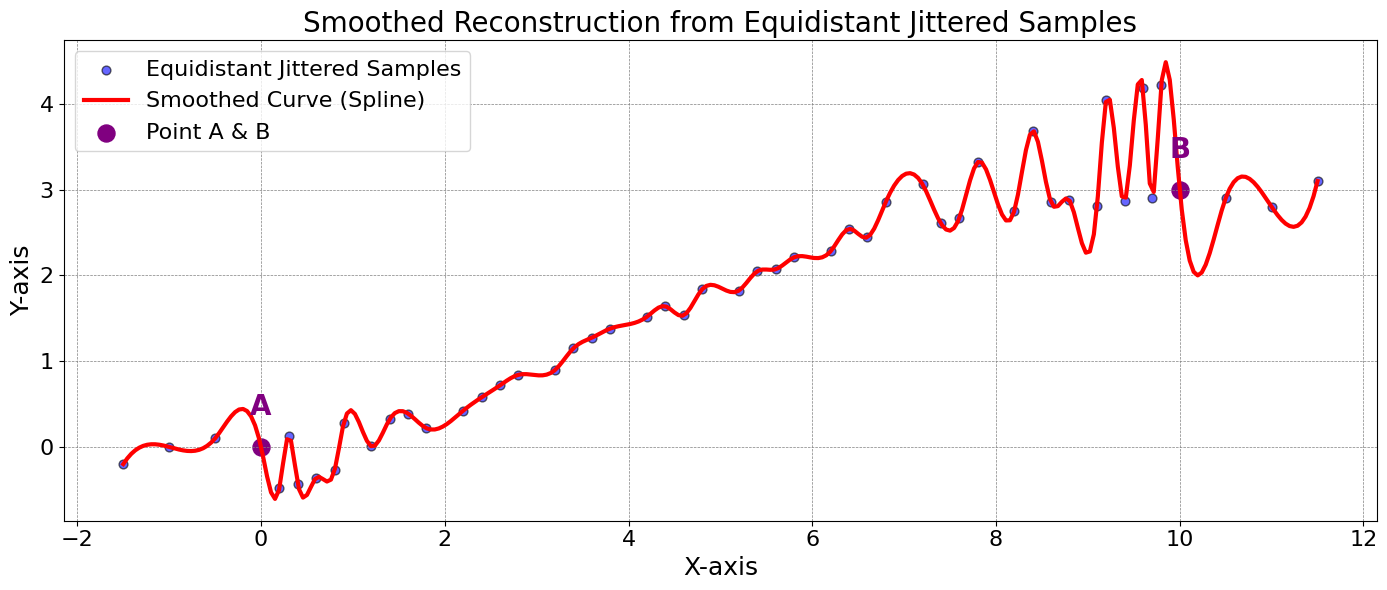

In [81]:
# Create figure with white background
plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.set_facecolor('white')

# Scatter the jittered equidistant points
plt.scatter(x_vals, y_vals,
            color='blue', s=40, label='Equidistant Jittered Samples', edgecolors='k', alpha=0.6)

# Plot smoothed curve
plt.plot(x_interp, y_interp, 'r-', linewidth=3, label='Smoothed Curve (Spline)')

# Plot and annotate Points A and B (same color and size)
plt.scatter(*A, color='purple', s=150, label='Point A & B')
plt.scatter(*B, color='purple', s=150)
plt.text(A[0], A[1] + 0.3, 'A', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')
plt.text(B[0], B[1] + 0.3, 'B', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')

# Axes and grid settings
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend(fontsize=16)
plt.title("Smoothed Reconstruction from Equidistant Jittered Samples", fontsize=20)
plt.xlabel("X-axis", fontsize=18)
plt.ylabel("Y-axis", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()


### Forward and Backward line fitting up to the mid-point)

In [83]:
# Split forward and backward sampling at the midpoint between A and B
mid_x = (A[0] + B[0]) / 2

In [84]:
# Forward sampling until midpoint
jittered_A_half = initial_points_A.tolist()
x_current_A = A[0]
lines_A_half = []
first_extension_A = True

In [85]:
while x_current_A < mid_x:
    fit_range = 2.0 if not first_extension_A else 1.5
    extension = 1.0 if not first_extension_A else 1.5
    win_start = x_current_A - fit_range
    points_in_win = np.array([p for p in jittered_A_half if win_start <= p[0] <= x_current_A])
    if len(points_in_win) < 2:
        break
    slope, intercept = fit_line_segment(points_in_win)
    lines_A_half.append((slope, intercept, x_current_A, x_current_A + extension))
    new_samples = sample_and_jitter_equidistant(x_current_A, slope, intercept,
                                                extension, num_samples, max_jitter, B[1])
    jittered_A_half.extend(new_samples.tolist())
    x_current_A += step_size
    first_extension_A = False
    if x_current_A > mid_x:
        break

In [86]:
# Backward sampling until midpoint
jittered_B_half = initial_points_B.tolist()
x_current_B = B[0]
lines_B_half = []
first_extension_B = True

while x_current_B > mid_x:
    fit_range = 2.0 if not first_extension_B else 1.5
    extension = 1.0 if not first_extension_B else 1.5
    win_end = x_current_B + fit_range
    points_in_win = np.array([p for p in jittered_B_half if x_current_B <= p[0] <= win_end])
    if len(points_in_win) < 2:
        break
    slope, intercept = fit_line_segment(points_in_win)
    lines_B_half.append((slope, intercept, x_current_B, x_current_B - extension))
    new_samples = sample_and_jitter_equidistant(x_current_B, slope, intercept,
                                                extension, num_samples, max_jitter, A[1], reverse=True)
    jittered_B_half.extend(new_samples.tolist())
    x_current_B -= step_size
    first_extension_B = False
    if x_current_B < mid_x:
        break

In [87]:
# Combine half-way points and smooth
half_points = np.array(jittered_A_half + jittered_B_half)
half_points = half_points[np.argsort(half_points[:, 0])]

# Handle duplicate x values
x_half_vals, indices = np.unique(half_points[:, 0], return_index=True)
y_half_vals = [np.mean(half_points[half_points[:, 0] == x, 1]) for x in x_half_vals]

spline_half = CubicSpline(x_half_vals, y_half_vals)
x_interp_half = np.linspace(x_half_vals.min(), x_half_vals.max(), 300)
y_interp_half = spline_half(x_interp_half)

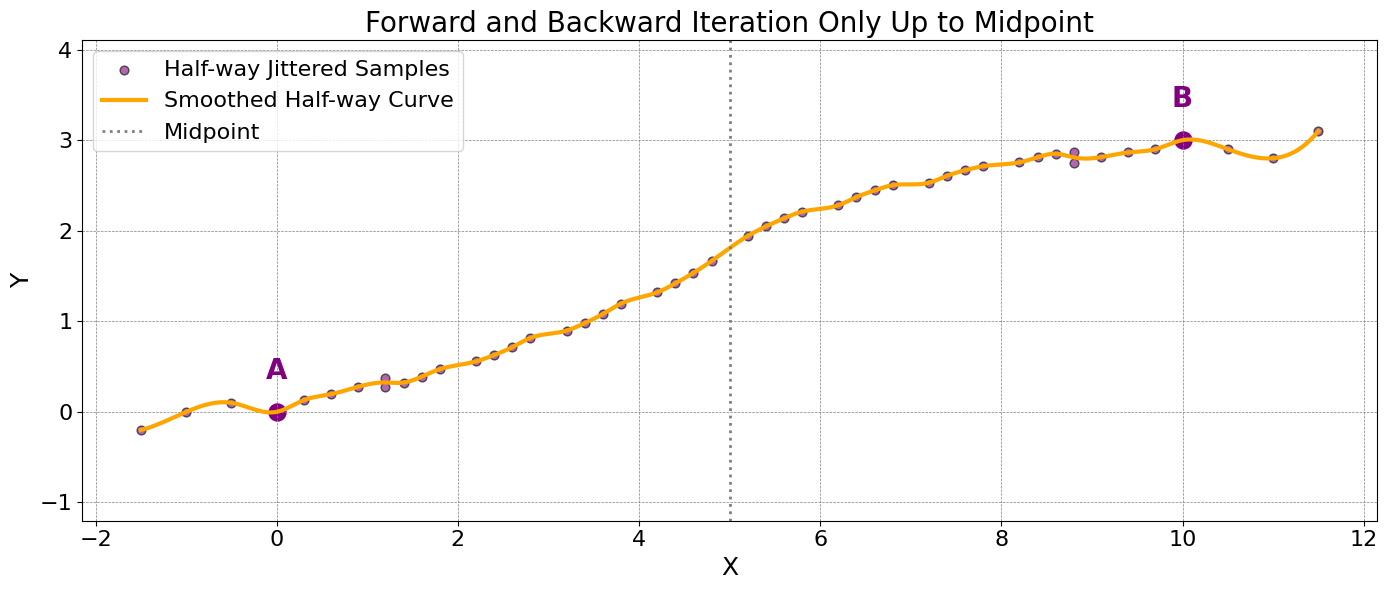

In [89]:
plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.set_facecolor('white')

# Plot half-way jittered samples
plt.scatter(half_points[:, 0], half_points[:, 1],
            color='purple', s=40, label='Half-way Jittered Samples', edgecolors='k', alpha=0.6)

# Plot smoothed half-way curve
plt.plot(x_interp_half, y_interp_half, color='orange', linewidth=3, label='Smoothed Half-way Curve')

# Vertical line at midpoint
plt.axvline(mid_x, color='gray', linestyle=':', linewidth=2, label='Midpoint')

# Plot Points A and B
plt.scatter(*A, color='purple', s=150)
plt.scatter(*B, color='purple', s=150)
plt.text(A[0], A[1] + 0.3, 'A', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')
plt.text(B[0], B[1] + 0.3, 'B', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')

# Final touches
plt.title("Forward and Backward Iteration Only Up to Midpoint", fontsize=20)
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.axis('equal')
plt.tight_layout()
plt.show()


### Bi-directional sampling: [A-->B] & [B-->A] with weighting

In [90]:
# Extract forward and backward points from full A-to-B sampling
points_forward = np.array(jittered_A)
points_backward = np.array(jittered_B)

# Sort for consistent interpolation
points_forward = points_forward[np.argsort(points_forward[:, 0])]
points_backward = points_backward[np.argsort(points_backward[:, 0])]

In [91]:
# Remove duplicate x values from forward and backward jittered samples
x_fwd_unique, idx_fwd = np.unique(points_forward[:, 0], return_index=True)
y_fwd_unique = [np.mean(points_forward[points_forward[:, 0] == x, 1]) for x in x_fwd_unique]

x_bwd_unique, idx_bwd = np.unique(points_backward[:, 0], return_index=True)
y_bwd_unique = [np.mean(points_backward[points_backward[:, 0] == x, 1]) for x in x_bwd_unique]

In [92]:
# Create interpolators
spline_forward = CubicSpline(x_fwd_unique, y_fwd_unique)
spline_backward = CubicSpline(x_bwd_unique, y_bwd_unique)

# Common x grid
x_common = np.linspace(min(x_fwd_unique.min(), x_bwd_unique.min()),
                       max(x_fwd_unique.max(), x_bwd_unique.max()), 500)

# Interpolated values
y_fwd = spline_forward(x_common)
y_bwd = spline_backward(x_common)

In [93]:
# Weights
def linear_weight(x, anchor, direction='forward'):
    if direction == 'forward':
        return np.clip(1 - (x - anchor) / (B[0] - A[0]), 0, 1)
    else:
        return np.clip((x - anchor) / (B[0] - A[0]), 0, 1)

weights_fwd = linear_weight(x_common, A[0], 'forward')
weights_bwd = linear_weight(x_common, A[0], 'backward')
total_weights = weights_fwd + weights_bwd
weights_fwd /= total_weights
weights_bwd /= total_weights

In [94]:
# Weighted average
y_combined = weights_fwd * y_fwd + weights_bwd * y_bwd

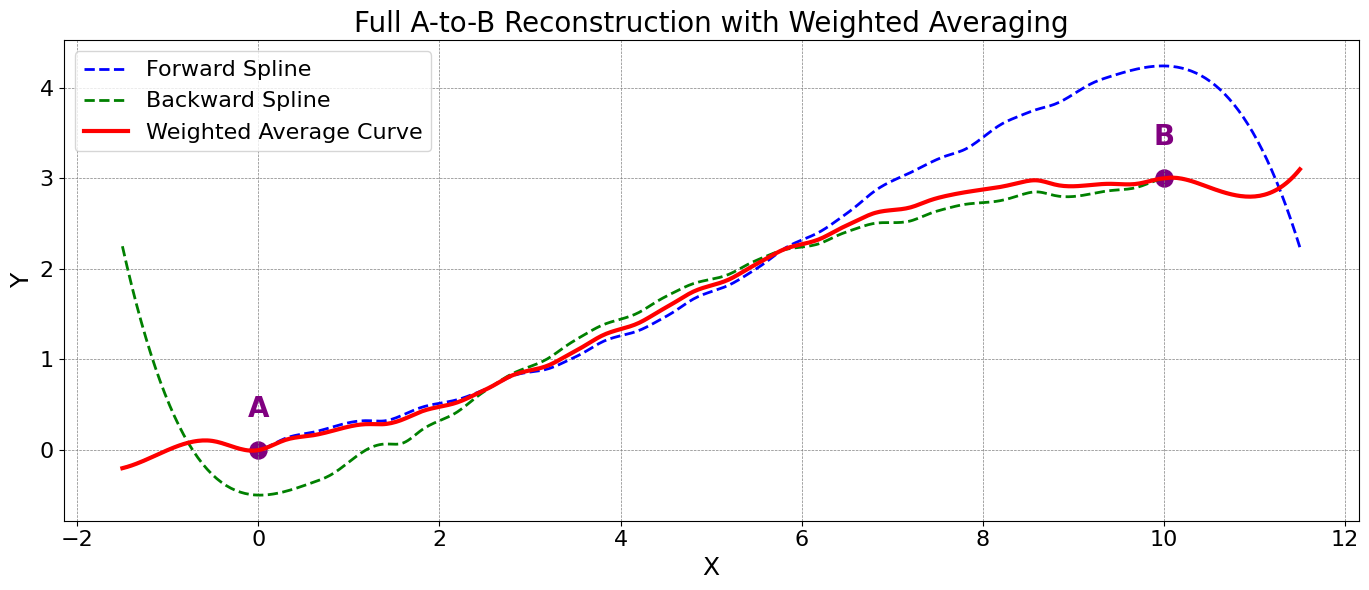

In [96]:
plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.set_facecolor('white')

# Plot splines
plt.plot(x_common, y_fwd, 'b--', linewidth=2, label='Forward Spline')
plt.plot(x_common, y_bwd, 'g--', linewidth=2, label='Backward Spline')
plt.plot(x_common, y_combined, 'r-', linewidth=3, label='Weighted Average Curve')

# Plot Points A and B
plt.scatter(*A, color='purple', s=150)
plt.scatter(*B, color='purple', s=150)
plt.text(A[0], A[1] + 0.3, 'A', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')
plt.text(B[0], B[1] + 0.3, 'B', fontsize=20, ha='center', va='bottom', fontweight='bold', color='purple')

# Titles, labels, and legend
plt.title("Full A-to-B Reconstruction with Weighted Averaging", fontsize=20)
plt.xlabel("X", fontsize=18)
plt.ylabel("Y", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.axis('equal')
plt.tight_layout()
plt.show()


## Enhanced Jittering Logic

### **Jitter Magnitude (Quadratic Weighting)**

For a sample point $P$ at relative position $w \in [0, 1]$ from its origin (A or B):

$$
\text{JitterMagnitude} = w^2 \cdot \epsilon_{\text{max}}
$$

Where:

- $w = \frac{|x_P - x_{\text{origin}}|}{\text{extension\_length}}$
- $\epsilon_{\text{max}}$: maximum allowable jitter (e.g., 0.2 m)

### **Jitter Direction (Vertical Only)**

Let:

- $y_P$: vertical coordinate of the sampled point  
- $y_{\text{ref}}$: y-value of the opposing anchor (A or B)

Direction logic:

$$
y_{\text{jittered}} = 
\begin{cases}
y_P + \text{JitterMagnitude}, & \text{if } y_P < y_{\text{ref}} \\
y_P - \text{JitterMagnitude}, & \text{if } y_P > y_{\text{ref}}
\end{cases}
$$

---

## Full A-to-B Reconstruction with Weighted Averaging

Two fronts are generated:
- Forward from Point A
- Backward from Point B

Each produces a curve, and the final reconstructed terrain is computed using a weighted average of both.

### **Weighted Average Formula**

Let:

- $x$: position along the X-axis  
- $y_{\text{fwd}}(x)$: value from forward spline (A→B)  
- $y_{\text{bwd}}(x)$: value from backward spline (B→A)

Define linear weights:

$$
w_{\text{fwd}}(x) = 1 - \frac{x - A_x}{B_x - A_x}, \quad 
w_{\text{bwd}}(x) = \frac{x - A_x}{B_x - A_x}
$$

Final reconstructed value:

$$
y_{\text{final}}(x) = 
\frac{
w_{\text{fwd}}(x) \cdot y_{\text{fwd}}(x) + w_{\text{bwd}}(x) \cdot y_{\text{bwd}}(x)
}{
w_{\text{fwd}}(x) + w_{\text{bwd}}(x)
}
$$


### Next:
PDE: Applying smoothing with <b>weight-sensitive regularization</b>, with regard to directionality and convergence pattern.

In [99]:
# PDE smoothing using 4th-order finite differences
def pde_smooth(x, y, alpha=1e-2):
    n = len(x)
    dx = np.diff(x)
    h = np.mean(dx)

    diagonals = [
        np.ones(n) * 6,
        np.ones(n - 1) * -4,
        np.ones(n - 2),
    ]
    L = diags(diagonals + diagonals[::-1], [0, 1, 2, -1, -2], shape=(n, n)).toarray()
    L[0, :] = L[1, :] = L[-1, :] = L[-2, :] = 0  # natural boundaries
    A = np.eye(n) + alpha * (L / (h ** 4))

    return spsolve(A, y)

# Generate forward and backward jittered points
def generate_jittered_points(A, B, num_steps=6, extension=1.0, num_samples=4, jitter_max=0.2):
    jittered_A, jittered_B = [], []

    for i in range(num_steps):
        # Forward from A
        start_x = A[0] + i * extension
        w = np.linspace(0, 1, num_samples)
        x = start_x + w * extension
        y_base = A[1] + (B[1] - A[1]) * (x - A[0]) / (B[0] - A[0])
        jitter = (w ** 2) * jitter_max
        y = np.where(y_base < B[1], y_base + jitter, y_base - jitter)
        jittered_A.extend(np.column_stack((x, y)).tolist())

        # Backward from B
        start_x = B[0] - i * extension - extension
        w = np.linspace(0, 1, num_samples)
        x = start_x + w * extension
        y_base = B[1] - (B[1] - A[1]) * (B[0] - x) / (B[0] - A[0])
        jitter = (w ** 2) * jitter_max
        y = np.where(y_base < A[1], y_base + jitter, y_base - jitter)
        jittered_B.extend(np.column_stack((x, y)).tolist())

    return np.array(jittered_A), np.array(jittered_B)

# Ensure strictly increasing x-values by averaging duplicates before interpolation

def remove_duplicate_x(points):
    x_unique = np.unique(points[:, 0])
    y_avg = [np.mean(points[points[:, 0] == x, 1]) for x in x_unique]
    return np.array(x_unique), np.array(y_avg)

In [100]:
# Recreate points
A = np.array([0.0, 0.0])
B = np.array([10.0, 3.0])
jittered_A, jittered_B = generate_jittered_points(A, B)

In [101]:
# Method 1: Midpoint only
mid_x = (A[0] + B[0]) / 2
points_half = np.vstack([
    jittered_A[jittered_A[:, 0] <= mid_x],
    jittered_B[jittered_B[:, 0] >= mid_x]
])
points_half = points_half[np.argsort(points_half[:, 0])]

In [102]:
# Method 2: Full weighted averaging
points_full = np.vstack([jittered_A, jittered_B])
points_full = points_full[np.argsort(points_full[:, 0])]

In [103]:
x_half_vals, y_half_vals = remove_duplicate_x(points_half)
x_full_vals, y_full_vals = remove_duplicate_x(points_full)

In [104]:
# Spline fits
spline_half = CubicSpline(x_half_vals, y_half_vals)
x_half = np.linspace(x_half_vals.min(), x_half_vals.max(), 300)
y_half_spline = spline_half(x_half)

spline_full = CubicSpline(x_full_vals, y_full_vals)
x_full = np.linspace(x_full_vals.min(), x_full_vals.max(), 300)
y_full_spline = spline_full(x_full)

In [105]:
def pde_smooth_fixed(x, y, alpha=1e-2):
    '''
    This function fixes the mismatched diagonals issue for the PDE smoother
    '''
    n = len(x)
    dx = np.mean(np.diff(x))

    main_diag = np.ones(n) * 6
    off1 = np.ones(n - 1) * -4
    off2 = np.ones(n - 2)

    diagonals = [main_diag, off1, off2, off2, off1]
    offsets = [0, 1, 2, -2, -1]

    L = diags(diagonals, offsets).toarray()
    L[0, :] = L[1, :] = L[-1, :] = L[-2, :] = 0  # natural boundary conditions
    A = np.eye(n) + alpha * (L / dx**4)

    return spsolve(A, y)

In [106]:
# Apply fixed PDE smoother
y_half_pde = pde_smooth_fixed(x_half, y_half_spline)
weights_full = np.abs((x_full - A[0]) * (x_full - B[0]))
weights_full = 1 - (weights_full / np.max(weights_full))
y_full_pde = pde_smooth_fixed(x_full, y_full_spline, alpha=1e-2 * weights_full.mean())

/var/folders/81/_6ygh6ss3fxfv0qnl09d96000000gn/T/ipykernel_92759/1944601708.py:19: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(A, y)


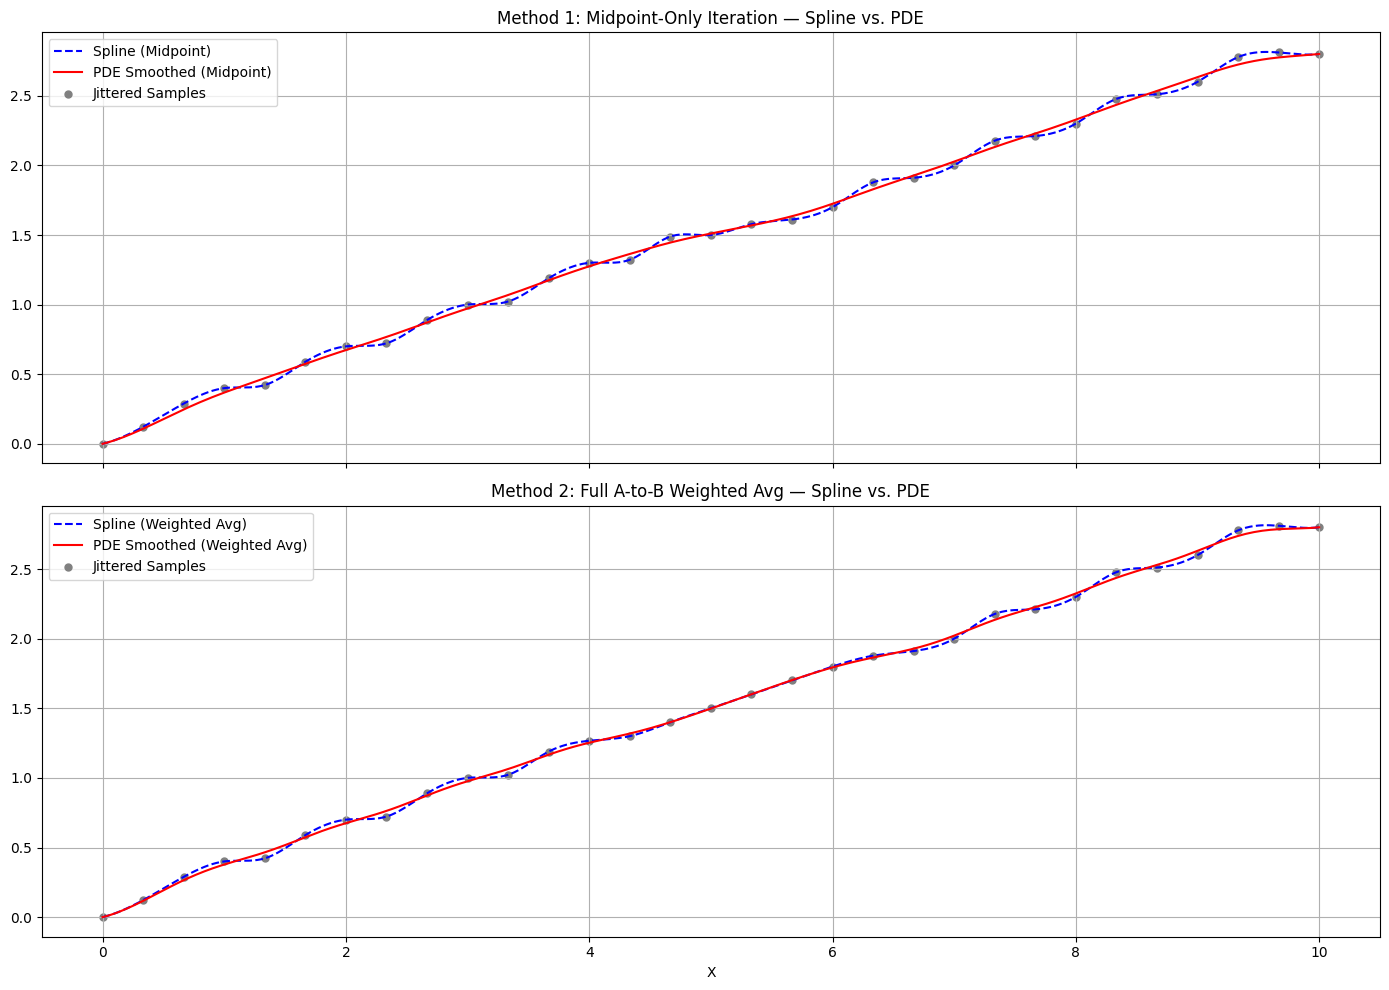

In [107]:
# Plot comparison
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

axs[0].plot(x_half, y_half_spline, 'b--', label='Spline (Midpoint)')
axs[0].plot(x_half, y_half_pde, 'r-', label='PDE Smoothed (Midpoint)')
axs[0].scatter(x_half_vals, y_half_vals, color='gray', s=25, label='Jittered Samples')
axs[0].set_title("Method 1: Midpoint-Only Iteration — Spline vs. PDE")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_full, y_full_spline, 'b--', label='Spline (Weighted Avg)')
axs[1].plot(x_full, y_full_pde, 'r-', label='PDE Smoothed (Weighted Avg)')
axs[1].scatter(x_full_vals, y_full_vals, color='gray', s=25, label='Jittered Samples')
axs[1].set_title("Method 2: Full A-to-B Weighted Avg — Spline vs. PDE")
axs[1].legend()
axs[1].grid(True)

plt.xlabel("X")
plt.tight_layout()
plt.show()
